Plot and summarize MultiNest samples using getdist over multiple datasets. Based on a script Wahid sent me.

In [1]:
# import anaconda3/personal python libraries
# TODO: maybe there's a cleaner way of doing this?
import sys
sys.path.append('~/anaconda3/lib/python3.6/site-packages/')

In [2]:
import numpy as np
import pandas as pd
import getdist
import getdist.plots as pt
import matplotlib.pyplot as plt
import effective_sample_size as sample_size
%matplotlib inline

In [95]:
parameters = [
                #'probs', 
                'alpha', 'beta', 'rx', 
               'rc', 'sigma_res',
              'cstar', 'xstar', 'mstar',
           #   'gc', 'gx', 'gm', 'eps',
              'omegam', 'omegade', 'h', 'loglike']
        
#parameters = ['loglike', 
      #        'prob', 
      #        'alpha', 'beta', 'rx', 'rc', 'sigma_res', 'cstar', 'gc', 'gx', 'gm', 'eps',
      #          'xstar', 'mstar', 'omegam', 'w', 'h']

param_plot_limits = {
    'alpha': (.12, .5), 'beta': (2.2, 5.6),
    'rx': (0.0, 2.5), 'rc':(0., 0.17), 'sigma_res':(0.0,0.4),
    'cstar': (-.05, 0.05), 'xstar':(-.12, 0.12), 'mstar':(-20., -19),
    'omegam': (-.1, 1), 'omegade': (-.1, 1.2), 'h': (.675, .725), 'loglike': (-120, 0)
}

param_true_values = {
    'alpha': .14, 'beta': 3.2,
    'rx': np.exp(.560333), 'rc': np.exp(-2.3171), 'sigma_res': 0.01,
    'cstar': -0.06, 'xstar': 0.0, 'mstar': -19.3,
    'omegam': .3, 'omegade': 0.7, 'h': .7, 'loglike': -78.2,
    'gc': -0.09669245704226216, 'gx': 0.038, 'gm': -0.5849406042825187, 'eps': 13.254733539684956
}

In [124]:
params_of_interest = [
                     'alpha', 'beta', 
                      'rx', 'rc', 'sigma_res',
                      'cstar', 'xstar', 'mstar',
                    #  'gc', 'gx', 'gm', 'eps', 
                     'omegam', 'omegade',
                       # 'h', 'loglike'
                                    ]
                      
labels_of_interest = [
                    '\\alpha', '\\beta', 
                      'r_x', 'r_c', '\\sigma_{res}',
                     'c_*', 'x_*', 'm_*',
                     # '\\gamma_c', '\\gamma_x', '\\gamma_m', '\\epsilon', 
                         '\\Omega_m', '\\Omega_{de}',
     
                       # 'h', 'loglike'
                             ] # for plotting

# load multinest results

In [125]:
#job_id = '2287722' # bahamas multiple run
job_id = '207881'
n_sims = 1

In [151]:
data = []
for i in range(n_sims):
    data_i = pd.read_csv('/c/Users/lucas/repositories/BAHAMAS_gibbs/gibbs_chains/post_chains.csv', sep=",", header=None)
    #data_i = pd.read_csv('/rds/general/user/tmakinen/home/WORK/{}[{}].cx1/.txt'.format(job_id, i+3), sep="\s+", header=None, encoding = "ISO-8859-1", error_bad_lines=False)
    #data_i = pd.read_csv('/rds/general/user/tmakinen/home/WORK/{}.cx1/.txt'.format(job_id), sep="\s+", header=None)
    data_i.columns = parameters
    data.append(data_i[params_of_interest][3000::10])

In [152]:
len(data[0]['sigma_res'])

400

(array([251., 100.,  21.,  10.,   4.,   3.,   0.,   6.,   3.,   2.]),
 array([0.02659328, 0.04425243, 0.06191157, 0.07957072, 0.09722987,
        0.11488901, 0.13254816, 0.1502073 , 0.16786645, 0.1855256 ,
        0.20318474]),
 <a list of 10 Patch objects>)

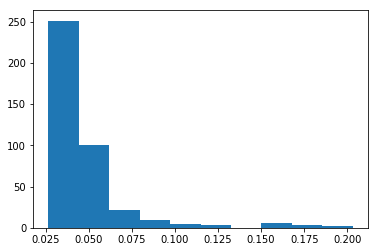

In [153]:
plt.hist(data[0]['sigma_res'])

# calculate summary statistics

In [154]:
true_values_of_interest = [param_true_values[label] for label in data[0].columns.values]
bias = [data_i.mean() - true_values_of_interest for data_i in data]
var = [data_i.var() for data_i in data]
mse = [var[i] + bias[i]**2 for i in range(n_sims)]

In [155]:
for i in range(n_sims):
    print('Simulation ', i)
    stats = pd.concat([bias[i].rename('bias'), var[i].rename('var'), mse[i].rename('mse')], axis=1)
    print(stats.T)

Simulation  0
         alpha      beta        rx        rc  sigma_res     cstar     xstar  \
bias  0.010769 -0.054177  0.031905  0.005349   0.038352  0.058667  0.021271   
var   0.001563  0.142405  0.004478  0.000085   0.000658  0.000040  0.006616   
mse   0.001679  0.145341  0.005496  0.000114   0.002129  0.003482  0.007069   

         mstar    omegam   omegade  
bias  0.055024  0.068910 -0.288480  
var   0.028562  0.037635  0.082371  
mse   0.031590  0.042384  0.165591  


In [156]:
# calculate summary bias and variance
# TODO: do these need to be reweighted?
# TODO: how meaningful are means of each statistic?
mean_bias = pd.concat(bias, axis=1).T.mean().to_frame('mean bias')
var_of_bias = pd.concat(bias, axis=1).T.var().to_frame('var of bias')
mean_var = pd.concat(var, axis=1).T.mean().to_frame('mean var')
mean_mse = pd.concat(mse, axis=1).T.mean().to_frame('mean mse')

In [157]:
summarystats = pd.concat([mean_bias, var_of_bias, mean_var, mean_mse], axis=1)
print(summarystats)
summarystats.to_csv('../{}.csv'.format(job_id))

           mean bias  var of bias  mean var  mean mse
alpha       0.010769          NaN  0.001563  0.001679
beta       -0.054177          NaN  0.142405  0.145341
rx          0.031905          NaN  0.004478  0.005496
rc          0.005349          NaN  0.000085  0.000114
sigma_res   0.038352          NaN  0.000658  0.002129
cstar       0.058667          NaN  0.000040  0.003482
xstar       0.021271          NaN  0.006616  0.007069
mstar       0.055024          NaN  0.028562  0.031590
omegam      0.068910          NaN  0.037635  0.042384
omegade    -0.288480          NaN  0.082371  0.165591


# create posterior corner plot

In [158]:
mcsamples = [getdist.MCSamples(samples=data_i.values, 
                               names=params_of_interest, 
                               labels=labels_of_interest) for data_i in data]
mcsamples.append(getdist.MCSamples(samples=pd.concat(data).values, 
                                   names=params_of_interest, 
                                   labels=labels_of_interest))

Removed no burn in
Removed no burn in


In [159]:
# plot settings
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

contour_args = []
line_args = []
legend_labels = []

for i in range(n_sims):
    contour_args.append({'color': colors[i]})
    line_args.append({'lw': .75, 'ls': '-', 'color': colors[i]})
    legend_labels.append('sample {}'.format(i+1))
    
#contour_args.append({'color': '#000000'})
#line_args.append({'lw': 2, 'ls': '-', 'color': '#000000'})
#legend_labels.append('combined')

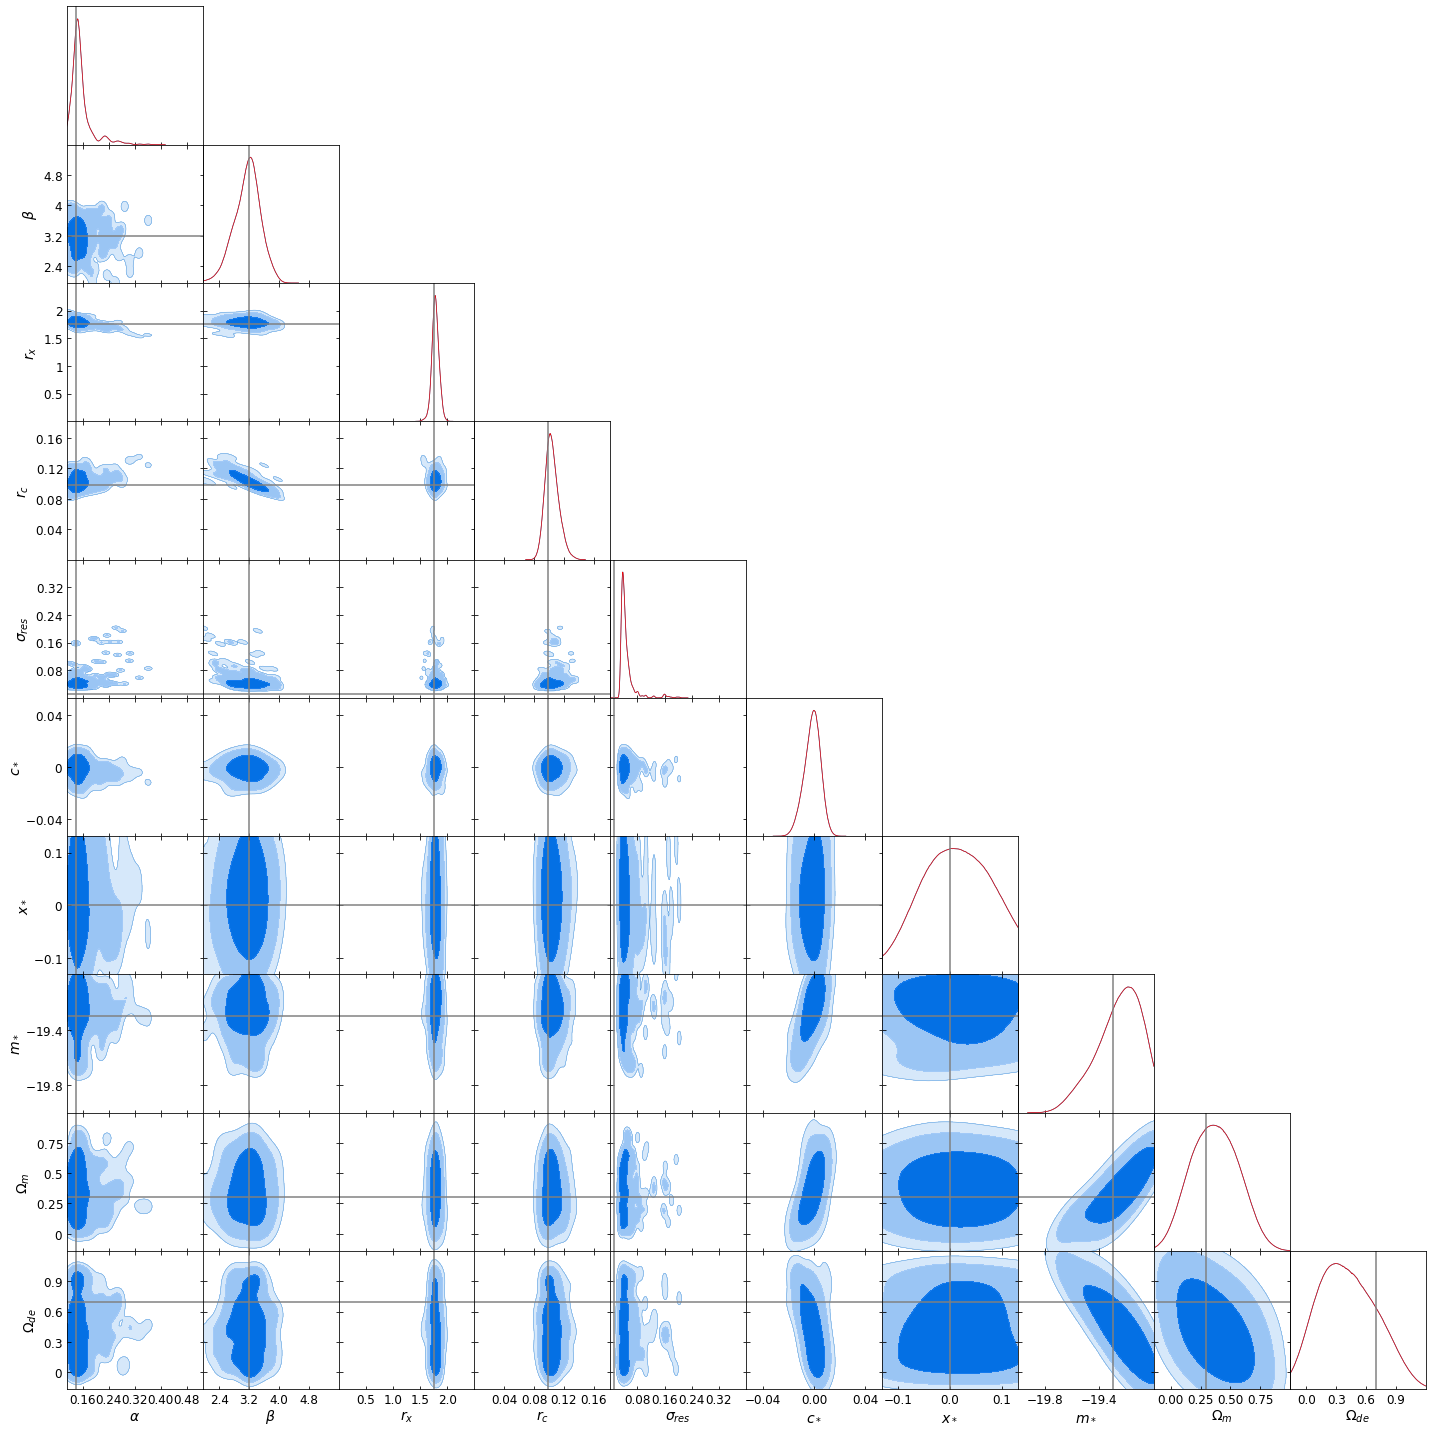

In [160]:
plotter = pt.getSubplotPlotter()
plotter.settings.num_plot_contours = 3
plotter.settings.rcSizes(12, 14, 12)
i
plotter.triangle_plot(mcsamples, filled=True, 
                      legend_labels=legend_labels, legend_ncol=2,
                      contour_args=contour_args, line_args=line_args,
                      param_limits=param_plot_limits)

# draw true value lines
for i in range(len(plotter.subplots)):
    for j in range(len(plotter.subplots[i])):
        subplot = plotter.subplots[i][j]
        if subplot is not None:
            if i > j: # only draw horizontal line for 2D plots
                subplot.axhline(param_true_values[params_of_interest[i]], color='gray')
            subplot.axvline(param_true_values[params_of_interest[j]], color='gray')

#plt.savefig('/mnt/c/Users/lucas/repositories/BAHAMAS/plots/{}.png'.format(job_id), dpi='figure')
#plt.savefig('/mnt/c/Users/lucas/Documents/Imperial/meetings/6_3_19/conditional_draws/full_gibbs_1.png', dpi='figure')
plt.show()

In [161]:
# compute effective sample size
ess_pars = ['alpha', 'beta', 'omegam', 'omegade']
for param in ess_pars:
    param_vec = data[0][param].values
    ess = sample_size.effectiveSampleSize(param_vec)
    print('ESS for {}'.format(param), ess)

ESS for alpha 348.12236034622094
ESS for beta 143.59168866342225
ESS for omegam 29.685170878203518
ESS for omegade 25.395560097977576


In [ ]:
0.4**2

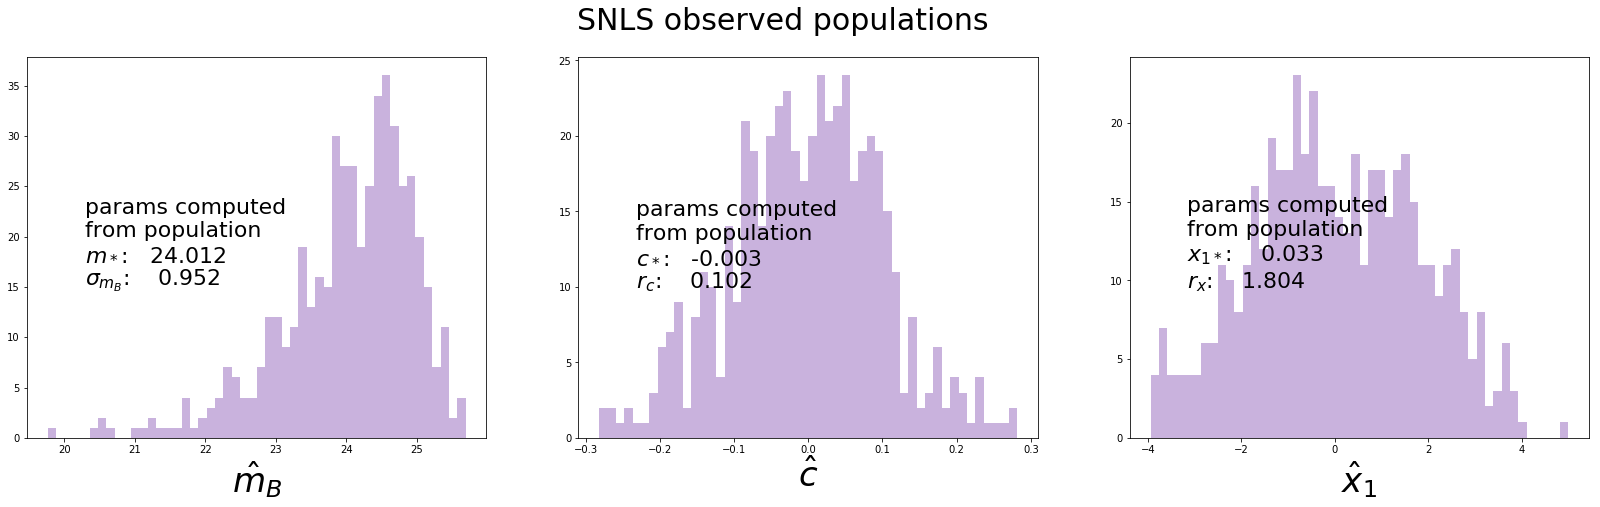

In [177]:
data = pd.read_csv('/c/Users/lucas/Datasets/mlacceleration/SNe_samples/test_1.txt', sep='\s+', header=0)


    
latent_plot_labels = [r'$\hat{m}_B$', r'$\hat{c}$', r'$\hat{x}_1$']
latent_labels = [
                        [r'$m_*$', r'$\sigma_{m_B}$'],
                        [r'$c_*$', r'$r_c$'],
                        [r'$x_{1*}$', r'$r_x$']
    ]



latent_pops = [data['mB'].values, data['c'].values, data['x1'].values]

latent_means = [np.mean(i) for i in latent_pops]
latent_spreads = [np.std(i) for i in latent_pops]

    # from current chain position
    #latent_mean_chain = [param[7], param[5], param[6]]
    #latent_spread_chain = [param[4], param[3], param[2]]

fig,axs = plt.subplots(1, 3, figsize = (28,7))

    # data for comparison
    #data = pd.read_csv(datafname, sep='\s+', header=0)

    #data_pops = [data['mB'].values, data['c'].values, data['x1'].values]
    #data_spreads = [np.std(data['mB'].values)]

    #data_labels = [' $\hat{m_B}$', '$\hat{c}$', '$\hat{x_1}$']
#xlims = [(15, 27), (-0.8, 0.8), (-3.5, 3.5)]


for i in range(len(axs)):
        # plot data attributes
        #axs[0][i].hist()

    # plot selected SNe
    axs[i].hist(latent_pops[i], bins=50, color='#9467bd', alpha=0.5)

    axs[i].set_xlabel(latent_plot_labels[i], fontsize=34)

    # for text labels
    histo = np.histogram(latent_pops[i], bins=50)
    x_pos = np.median(histo[1]) - 1.4*np.std(histo[1])
    y_pos = 0.41*np.max(histo[0])

    s = 'params computed \nfrom population\n'
    s += latent_labels[i][0] + ': {0:8.3f} '.format(latent_means[i]) + '\n'
    s += latent_labels[i][1] + ': {0:8.3f} '.format(latent_spreads[i])

        #s += '\n' + 'chain values \n'
        #s += latent_labels[i][0] + ': {0:8.3f} '.format(latent_mean_chain[i]) + '\n'
        #s += latent_labels[i][1] + ': {0:8.3f} '.format(latent_spread_chain[i])

    axs[i].text(x_pos, y_pos, s, fontsize=22)
    # restrict xlims to observed SNe    
    #axs[i].set_xlim(xlims[i])    
    # add labels
    #axs[i].set_xlabel(latent_names[i], fontsize=25)
    #axs[i].set_ylabel('$p(S_i=1|$' + latent_names[i] + '$)$', fontsize=22)
fig.suptitle('SNLS observed populations', fontsize=30)
#plt.subplots_adjust(wspace=0.3, left=0.125)

#fig.suptitle('Selection Function Classifier on Test SNIa set', fontsize=17)
#axs[2].legend(loc='best', fontsize=11)
plt.savefig(fname='/c/Users/lucas/Documents/Imperial/meetings/6_3_19/latent_distr_comp.png', dpi='figure')